# DT2470 Lab 01: Teh Signal Processings

by Bob L. T. Sturm

In this first lab you will practice some fundamental concepts of signal processing. You will analyse a chosen sampled sound in the time-, frequency-, and time-frequency domains. You will write something intelligent about your analysis, observing things like periodicity, frequency content, harmonicity, etc. You will also learn to extract low-level features from audio and music signals. In the next lab, you will use these features for some machine learning madness.

The lab report you submit should be a testament to your intelligence, as well as a reflection of your willingness to be a part of this module. You are free to use whatever software you want, e.g., python, MATLAB, Processing, C++, etc. But I give tips below in python. Here's some helpful links as well:

- [Numpy API](https://docs.scipy.org/doc/numpy-1.13.0/index.html)
- [Scikit-learn API](https://scikit-learn.org/stable/)
- [MatPlotlib API](https://matplotlib.org/3.1.1/api/index.html)
- [Numpy Cheat Sheet](https://www.dataquest.io/blog/numpy-cheat-sheet/)
- [Pydub API](https://github.com/jiaaro/pydub/blob/master/API.markdown)

I also include some images so you can confirm whether you are on the right track, or just to have a brief pause to laugh at how far your answer is from being correct.

# Part 1: Basics

1. Choose an audio file to work with from http://bbcsfx.acropolis.org.uk. Download it, load it using pydub (see [pydub.AudioSegment](https://github.com/jiaaro/pydub/blob/master/API.markdown)), and plot a portion of the waveform with the appropriate axes labeled "Amplitude" and "Time (s)". The time axis **must be** in seconds. (Use the sample rate of your soundfile to find that.) If your audio file has more than one channel, just look at one channel.

> Below is the first 10 seconds of my selected audio waveform. Yours should appear nearly as beautiful.
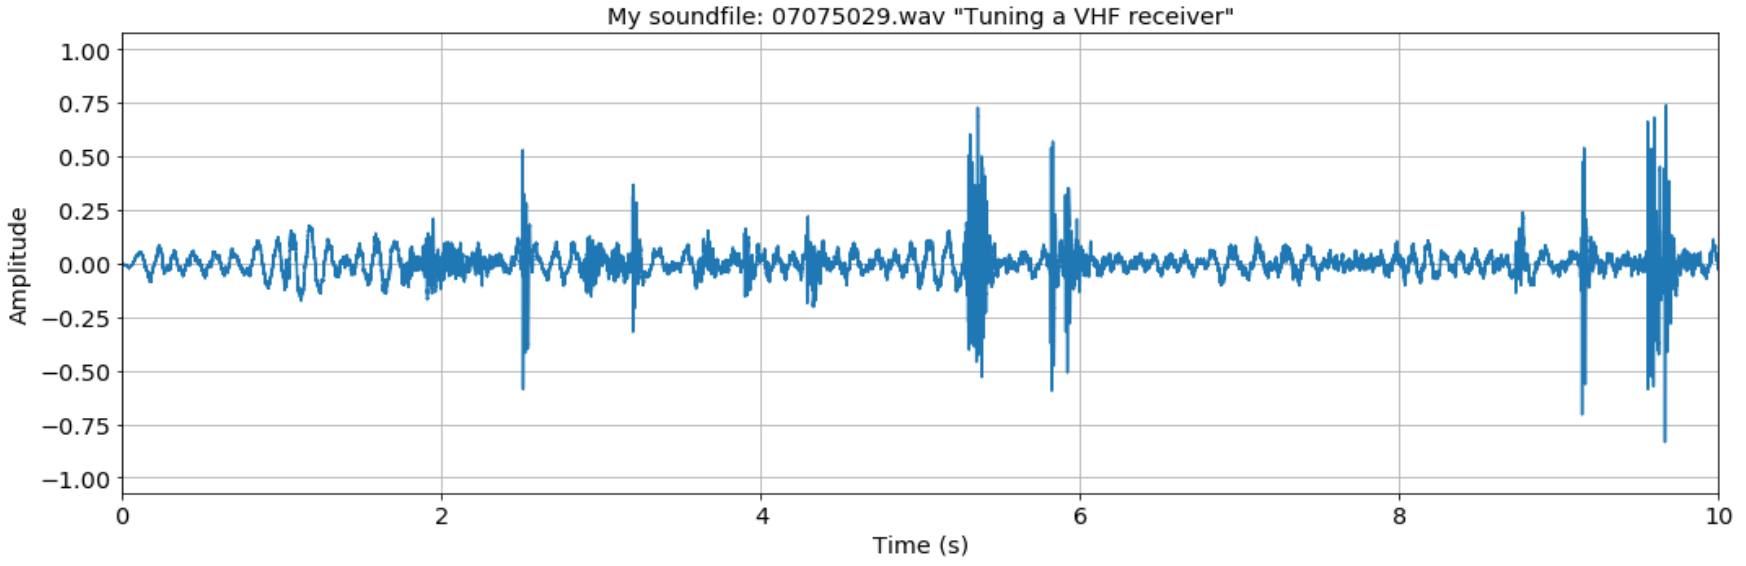

In [5]:
# Here is a how I download an audio file 
import os
import wget
# snd_dir = '/tmp/snd'

# if not os.path.exists(snd_dir):
    # os.makedirs(snd_dir)
# !wget --quiet -P /tmp/snd/ http://bbcsfx.acropolis.org.uk/assets/07075029.wav
filename = "res/07075006.wav"
# filename = "res/07075029.wav"
if not os.path.isfile(filename):
    wget.download("http://bbcsfx.acropolis.org.uk/assets/07075006.wav", out=filename)
    # wget.download("http://bbcsfx.acropolis.org.uk/assets/07075029.wav", out=filename)


### My notes:
Below I plot, first the entire sound file I have downloaded, then the first 10 seconds only. Librosa seems to normalize
the amplitudes, which makes the plots similar to the example plots. The plot function I define here will be used more
throughout the lab.

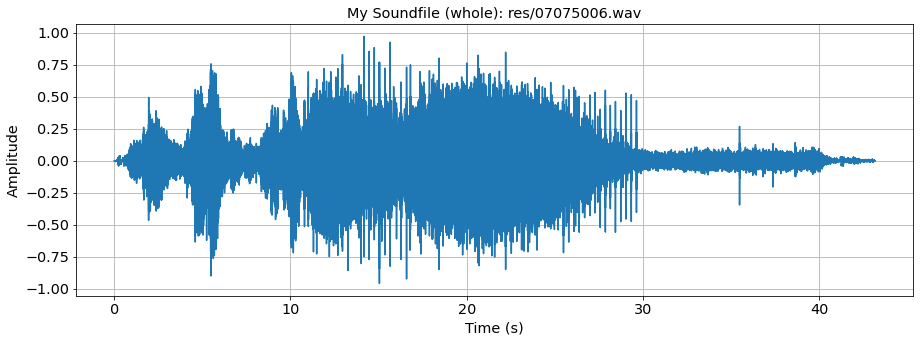

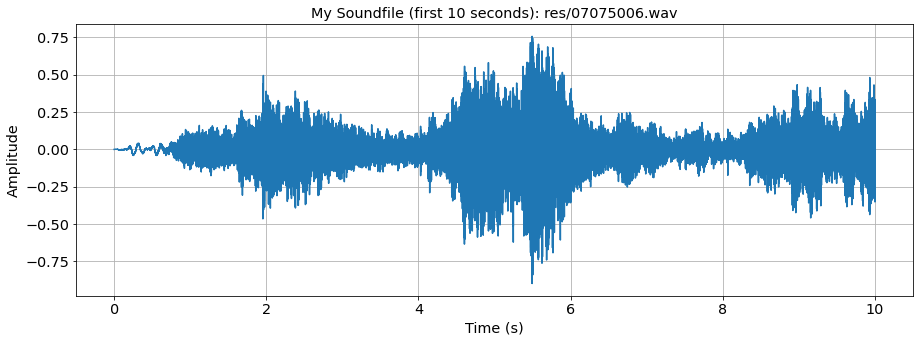

In [6]:
# Now we plot the entire audio file
import pydub
import matplotlib.pyplot as plt
import numpy as np
# from scipy.io import wavfile
import librosa

# The following makes the plot look nice
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

# add your code below

# Sampling Rate is in samples per second, data is dict with key "data" which is 1-D array
# Multiple channels (stereo) are mixed into one channel (mono) by default. Hence the 1-D array.
data, samplingRate = librosa.load(filename)
samples = np.array(data.data)

def plotFunc(xVals, yVals, title, xLabel, yLabel):
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.title(title)
    plt.plot(xVals, yVals)
    plt.grid()
    plt.show()

# xAxis in seconds: sampleIndex / samplesPerSecond = time, equivalent to distance / velocity = time
xValues1 = np.arange(len(samples)) / samplingRate
title1 = "My Soundfile (whole): " + filename
plotFunc(xValues1, samples, title1, "Time (s)", "Amplitude")

# Plot first 10 seconds
numSamples = samplingRate * 10
xValues2 = np.arange(numSamples) / samplingRate
yValues2 = samples[:numSamples]

title2 = "My Soundfile (first 10 seconds): " + filename
plotFunc(xValues2, yValues2, title2, "Time (s)", "Amplitude")


2. With the audio file you have chosen, zoom into two different 100 ms portions that have audio data and plot them. 

>Below is what mine looks like. We can see the sound appears quite different at both times. At  about 2500 ms we see a sudden rise that decays and oscillates. At about 26 s we see a noisy waveform that has a small amplitude. 

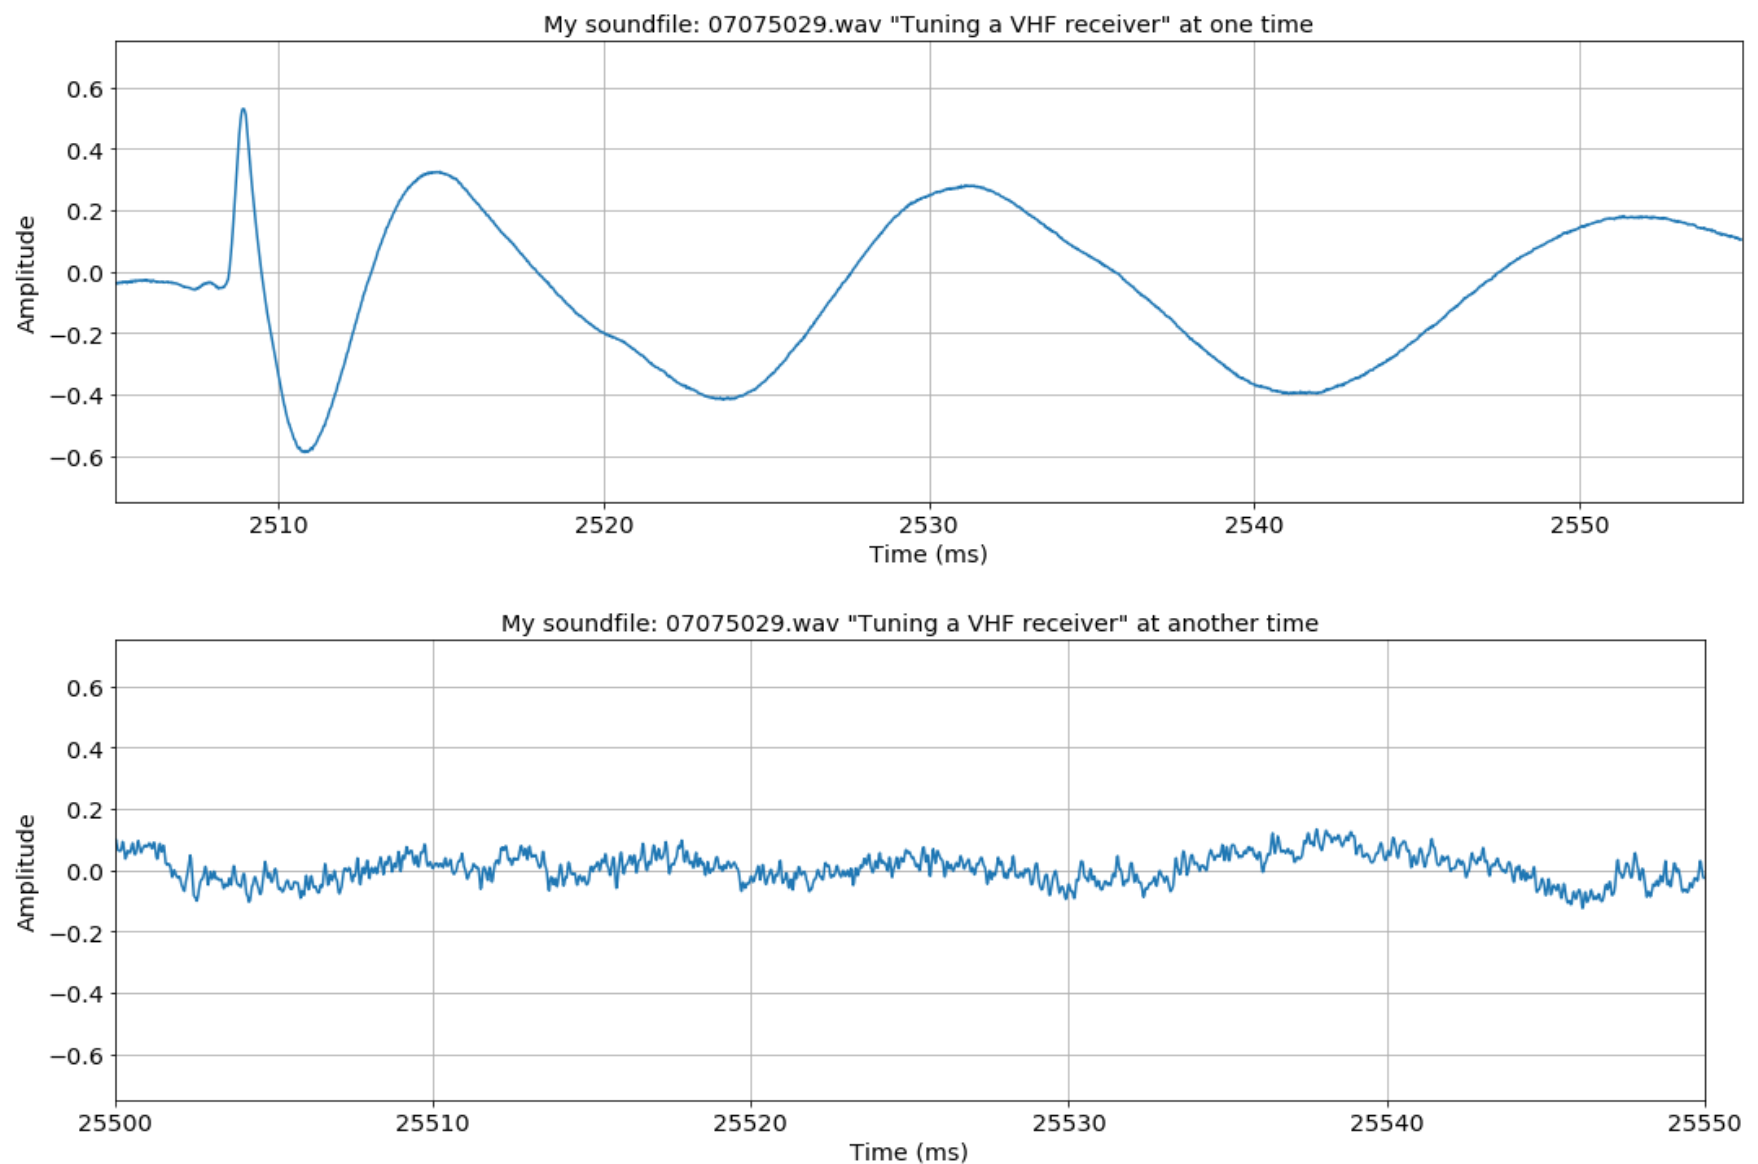


### My notes:
Below I zoom into two different 100ms portions. This is all done by array indexing with the help of the sampling rate.
I find the number of samples required to cover the 100ms range, then I find the first sample of that range and
extract these samples from the data.

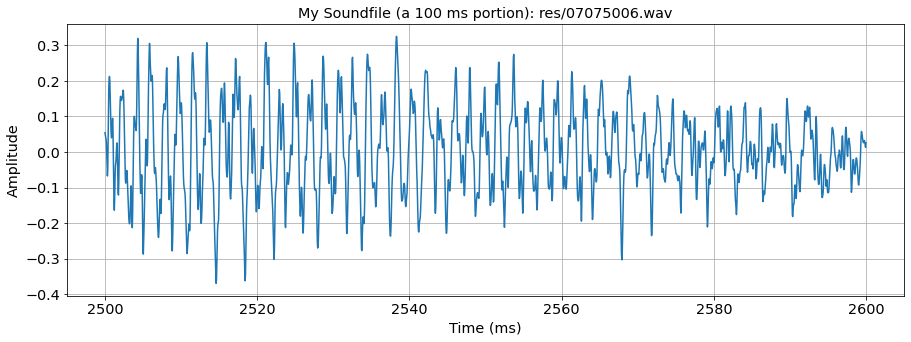

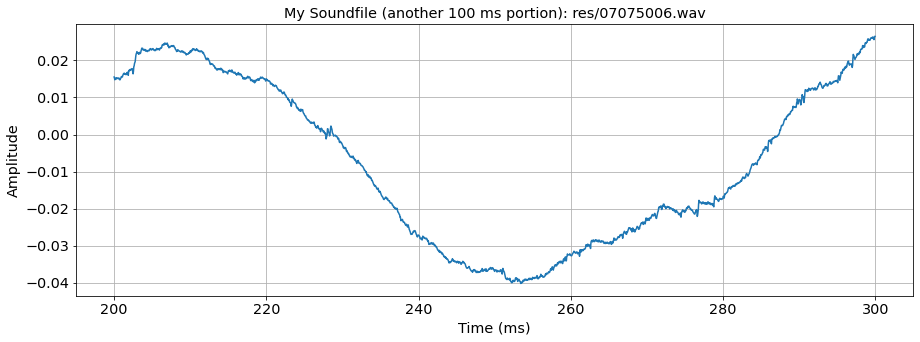

In [7]:
# Zoom into two different 100ms portions
numSamples = int(samplingRate * 0.1)

def calcXYValuesFor100msPortion(startTime):
    xVals = np.arange(numSamples) / samplingRate * 1000
    xVals = xVals + startTime * 1000
    startSample = int(samplingRate * startTime)
    yVals = samples[startSample:startSample + numSamples]
    return xVals, yVals

# Start time in seconds
startTime1 = 2.5
xValues3, yValues3 = calcXYValuesFor100msPortion(startTime1)
title3 = "My Soundfile (a 100 ms portion): " + filename
plotFunc(xValues3, yValues3, title3, "Time (ms)", "Amplitude")

# This captures a less noisy area, but still with small oscillations
startTime2 = 0.2
xValues4, yValues4 = calcXYValuesFor100msPortion(startTime2)
title4 = "My Soundfile (another 100 ms portion): " + filename
plotFunc(xValues4, yValues4, title4, "Time (ms)", "Amplitude")

3. For each of the segments you looked at above, window them, and compute their Fourier transforms. Plot their dB magnitude spectra. Appropriately label your axes with "Magnitude (dB)" and "Frequency (kHz)". The frequency axis **must be** in kiloHertz, and limited to 0 to the Nyquist frequency (half the sampling rate). Window the audio with 1) boxcar, or 2) Hann. (This means you will have create four plots in total , or two plots with two lines each.)

### My notes:
Below I use Librosa to perform the window function on the extracted data (with a window size covering the entire 100ms
portion). I scale the data with the window values and then use NumPy to perform the FFT on the data. The magnitude
coefficients are then normalized.

For the first 100ms portion we can see about 5 similar peaks per 10ms part. This is roughly 500 peaks (periods) per
second, which makes it reasonable that we should see a peak in about 0.5 kHz in the magnitude spectra. This can be seen
in the first 2 plots. The second two plots are a little bit more difficult to analyze as the frequency that is expected
to see there is (again found by counting peaks per millisecond in the above plot) about 10 Hz or 0.01 kHz. But we can
observe a peak close to this in the magnitude spectra.

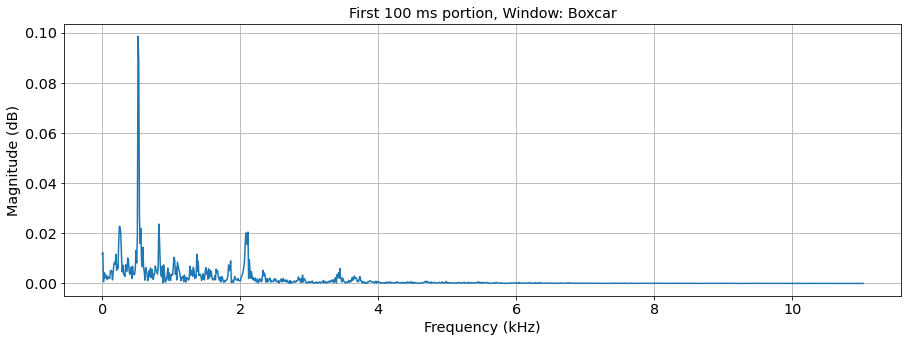

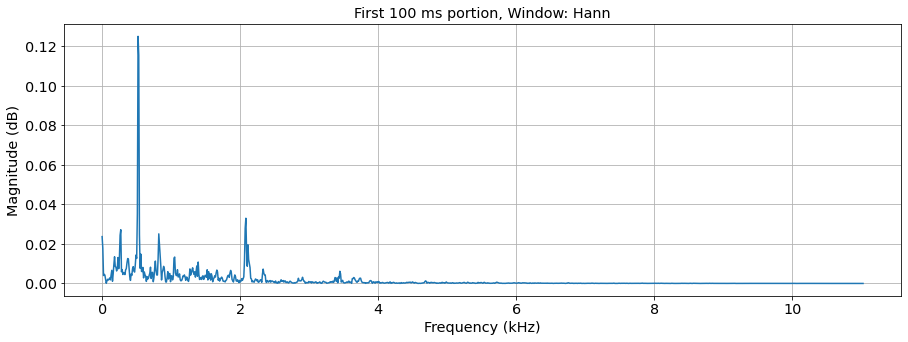

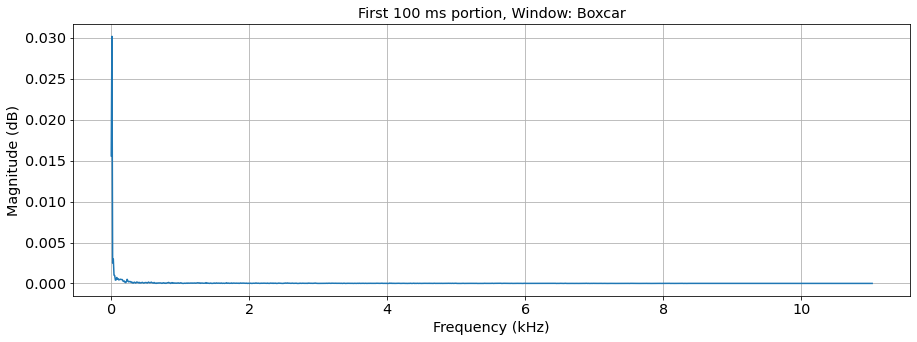

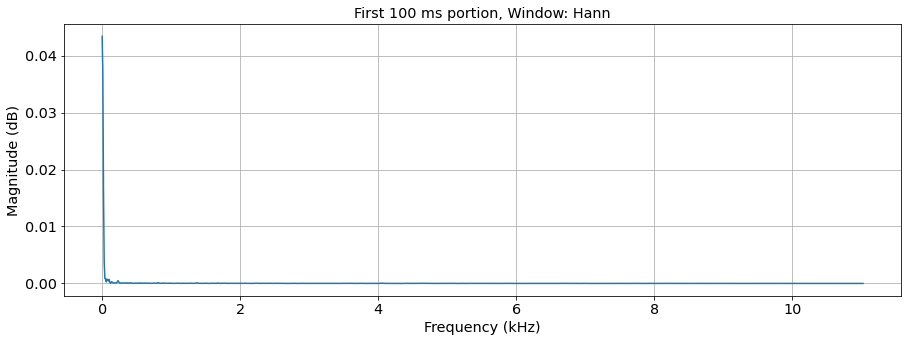

In [8]:
# add your code below

# returns frequency coefficients (k's) in Hz and magnitudes
def windowAndFftMagnitude(yVals, window, sampleFreq):
    N = len(yVals)
    windowVals = librosa.filters.get_window(window, N)
    yValsWindowed = yVals * windowVals
    yValsWindowedFft = np.fft.fft(yValsWindowed)
    xFreqs = np.linspace(0.0, sampleFreq/2, N//2)  # 0 -> Nyquist frequency, floor(N/2) samples
    magnitudes = np.abs(yValsWindowedFft[:N//2])
    # multiply by 2 since upper half is not considered (symmetry), normalize with sum of window values (dividing by N is correct only for boxcar window)
    return xFreqs, magnitudes * 2 / np.sum(windowVals)

# Threshold Of Hearing (TOH=1e-12) as reference
def decibel(intensity):
    return 10 * np.log10(intensity / 1e-12)


x, y = windowAndFftMagnitude(yValues3, 'boxcar', samplingRate)
plotFunc(x / 1000.0, y, "First 100 ms portion, Window: Boxcar", "Frequency (kHz)", "Magnitude (dB)")

x, y = windowAndFftMagnitude(yValues3, 'hann', samplingRate)
plotFunc(x / 1000.0, y, "First 100 ms portion, Window: Hann", "Frequency (kHz)", "Magnitude (dB)")

x, y = windowAndFftMagnitude(yValues4, 'boxcar', samplingRate)
plotFunc(x / 1000.0, y, "First 100 ms portion, Window: Boxcar", "Frequency (kHz)", "Magnitude (dB)")

x, y = windowAndFftMagnitude(yValues4, 'hann', samplingRate)
plotFunc(x / 1000.0, y, "First 100 ms portion, Window: Hann", "Frequency (kHz)", "Magnitude (dB)")


4. For the first 10 seconds of your audio file, compute and plot its dB magnitude short-time Fourier transform using a Hann window of duration 25 ms with a window hopsize of 10 ms, and an FFT size of 8192 samples. Do the same using a Hann window of duration 100 ms with a window hopsize of 10 ms. Appropriately label your axes with "Frequency (kHz)" and "Time (s)". The frequency axis must be in kiloHertz, and limited to 0 to 5 kHz. The time axis must be in seconds. Choose a colormap that you feel describes your personality (https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html). See [scipy.signal](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html) for help.

### My notes:

The y-values from the first 10 seconds of the audio wave lies in `yValues2` from earlier.

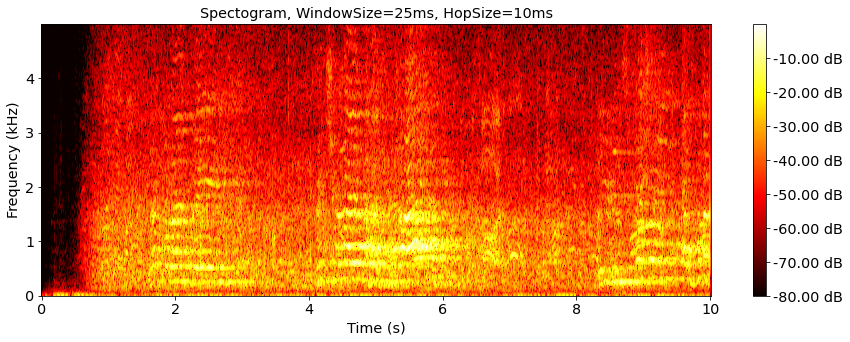

In [9]:
# add your code below
import scipy.signal
import librosa.display

samplesPerMs = samplingRate // 1000
# D = librosa.stft(yValues2, n_fft=8192, hop_length=samplesPerMs*10, win_length=samplesPerMs*25, window='hann')
freqs, times, D = scipy.signal.stft(yValues2, fs=samplingRate, window='hann', nperseg=int(samplesPerMs*25), noverlap=int(samplesPerMs*(25-10)), nfft=8192)
freqsIndicesIncluded = freqs <= 5000
DMagnitudes = np.abs(D)[freqsIndicesIncluded, :]
# ref = np.max(DMagnitudes) ** 2
# power = np.square(DMagnitudes)
# db = 10 * np.log10(power / ref)
# db = np.maximum(db, db.max() - 80.0)
db = librosa.amplitude_to_db(DMagnitudes, ref=np.max)
plt.pcolormesh(times, freqs[freqsIndicesIncluded] / 1000, db, shading='auto')
# librosa.display.specshow(librosa.amplitude_to_db(DMagnitudes, ref=np.max), y_axis='linear', x_axis='time')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (kHz)")
plt.title("Spectogram, WindowSize=25ms, HopSize=10ms")
plt.set_cmap("hot")
plt.colorbar(format='%+2.2f dB')
plt.show()

5. Describe some of the advantages and nackdelar of using short or long time windows for time-frequency analysis.

> We can see that the longer time window gives a thinner support on harmonics that have a nearly constant frequency, such as in the portion around 2 seconds. However, onsets appear sharper with the shorter window.



6. For the first 10 seconds of your audio file, use the [librosa package](https://github.com/librosa) to compute its Mel spectrogram using Hann windows of duration 25 ms with a window hopsize of 10 ms. Use 128 Mel bands and an FFT size of 8192 samples. Display the dB magnitude with reference to the max power observed, and limit your y-axis between 0 and 5 kHz. Use the same colormap as you used above. See https://github.com/librosa/librosa/blob/main/examples/LibROSA%20demo.ipynb for help. 

In [ ]:
import librosa
import librosa.display

# add your code below


# Part 2: Extracting features

1. Write a function that will take in the samples of an audio file, a frame size in samples, a frame hop size in samples, and compute and return the number of waveform zero crossings in each frame. A waveform x[n] undergoes a zero crossing when sign(x[n]) and sign(x[n+1]) are different. You will have to slice x[n] into chunks of a specified size, and for each of those chunks, count the number of sign changes.

In [ ]:
# add your code below


2. Using your function, compute zero crossings of 46 ms frames hopped 50% of that for the audio file you used in part 1. (Ignore any frames at the end of audio files that are less than that length.) Plot the first 10 seconds of your time domain waveform, and plot the series of zero crossings you extracted.

In [ ]:
# add your code below


3. Write a function that will take in the samples of an audio file, a frame size in samples, a hop size in samples, and a sampling rate, and compute and return the spectral centroid of each frame. The spectral centroid of a rectangular window of audio $x[n]$ of length $N$ (even) is defined as 
$$ R_{0.5}(x) = \frac{\sum_{k=0}^{N/2+1} \frac{F_s k}{N} |X[k]|}{\sum_{k=0}^{N/2+1} |X[k]|} $$
where $X[k]$ is the DFT of $x[n]$, and $F_s$ is the sampling rate.

In [ ]:
# add your code below


4. Using your function, compute spectral centroid features for contiguous 46 ms frames hopped 50% for the audio file you used in part 1. (Ignore any frames at the end of audio files that are less than that length.) Plot the first 10 seconds of your time domain waveform, and plot the series of spectral centroids you extracted.

In [ ]:
# add your code below


5. Using the librosa package (https://github.com/librosa), extract the first 10 MFCC features from your audio file using Hann windows of 25 ms duration and 10 ms hop size, and an FFT size of 8192 samples. Display the extracted MFCCs for the first 10 seconds.

In [ ]:
# add your code below


# Questions

- Why is there a square root of 2 in the formula for the magnitude coefficient? (eq. 2.14 on page 47 in course literature)
Is this relevant for practical applications that use libraries for FFT?
- When plotting Fourier Magnitude Coefficients, do we need to convert to Decibels? Will it become a problem that Librosa
seems to normalize the input amplitude with the maximum value? (locks amplitude to [-1, 1] ).
- What does it mean to say that Magnitude of FFT is in the unit dB?
- The table in the book refers dB to the TOH, is this always done in for example the spectograms as well?
